In [1]:
# install non standard packages
!pip install requests_cache

In [2]:
# import standard libraries
import io
import zipfile
import requests as rq
import requests_cache as rqc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import sklearn related libraries
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.metrics import classification_report, RocCurveDisplay

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline

# import imblearn to hanlde imbalances in the dataset
from imblearn.over_sampling import RandomOverSampler

# import data visualization tools
import seaborn as sns

# import text processing tools
import spacy
from nltk.stem import SnowballStemmer
import re

# import persistence support
from joblib import dump, load

In [3]:
# ensure reproducible results
rand_state = 1234

# Raw Data Acquisition

This section focuses on acquiring raw data so we retain only the relevant data and ensure dataset balance.

Acquire raw data and ensure basic formatting.

In [4]:
# get the data file
URL = "https://github.com/INTERTECHNICA-BUSINESS-SOLUTIONS-SRL/NATO-COVID-Fake-News-Detection-TFIDF/raw/main/data/COVIDFakeNewsProcessedData.zip"
response = rqc.CachedSession().get(URL)
binary_data = io.BytesIO(response.content)

In [5]:
# read the dataframe
FILE_NAME = "./COVIDFakeNewsProcessedData.csv"

raw_data = None
with zipfile.ZipFile(binary_data) as z:
   with z.open(FILE_NAME) as f:
     raw_data = pd.read_csv(f, index_col=None);

In [6]:
# preserve only the relevant data columns
# we will process it later on for classification purpose
COLUMNS = ["content", "binary_target"]
relevant_data_columns = raw_data.drop(raw_data.columns.difference(COLUMNS), axis=1)

One of the first things we need to use is to determine if the content length of the records is relatively uniform. The content length data is actually highlight right skewed, having a relatively small number of records with a high content length.

In [7]:
# extract content length data
content_length_data = relevant_data_columns["content"].apply(lambda x: len(x))

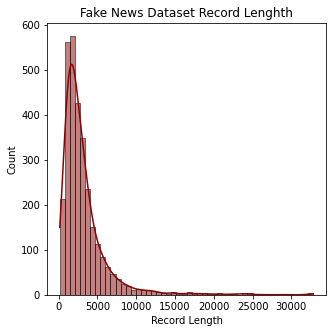

In [8]:
# display the histogram of content length
plt.figure(figsize=(5, 5))
plt.subplot2grid(shape=(1,1), loc=(0,0))
rel = sns.histplot(
    data=content_length_data,
    kde=True,
    color = "darkred",
    bins = 50
  )
rel.set_title('Fake News Dataset Record Lenghth')
rel.set_xlabel("Record Length")
plt.show()

In order to ensure a better classification we need to eliminate the records that are:


*   Very short: so they are uninformative;
*   Very large: so multiple topics may be mingled together and generating too much complexity. 

We will use the records having the content length between the 1st and 9th decile.


In [9]:
# eliminate outliers represented by very short or very long texts
# we will keep the texts within 1-st and 9-th decile
q_10_perc = content_length_data.quantile(0.1)
q_90_perc = content_length_data.quantile(0.9)

index_relevant_data = content_length_data[
                              (content_length_data > q_10_perc) & 
                              (content_length_data < q_90_perc)
                      ].index

relevant_data = relevant_data_columns.loc[index_relevant_data].reset_index(drop = True)

Check if the dataset is balanced, otherwise try to balance it.

In [10]:
def plot_dataset_balance(data) :
  """
  Plots the distribution of unique values in data.
  Parameters
  ----------
    data : array
      The data to be inspected
  """
  plot_labels = np.unique(data);
  plot_values = np.bincount(data)
  

  plt.figure(figsize=(5, 5))
  plt.subplot2grid(shape=(1,1), loc=(0,0))
  fig = sns.barplot(
      ["Veridic News", "Fake News"], 
      plot_values,
      palette = ['darkgreen', 'darkred']
    )
  fig.set_title('Veridic and Fake Dataset Distribution')
  plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


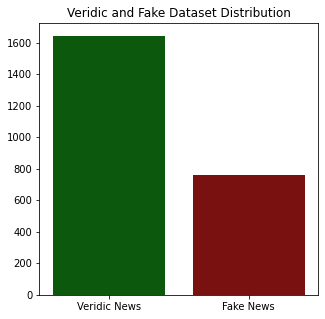

The dataset is imbalanced, the number of fake news is roughly half of the veridic news


In [11]:
# determine if the set is balanced apriori
plot_dataset_balance(relevant_data["binary_target"].to_numpy())
print("The dataset is imbalanced, the number of fake news is roughly half of the veridic news")

In [12]:
# we are dealing with an imbalaced dataset
# thus we will choose to oversample the minority class (fake news)
oversampler = RandomOverSampler(sampling_strategy = "minority", random_state = rand_state);
sampling_labels = relevant_data["binary_target"];
train_data_resampled, _ = oversampler.fit_resample(relevant_data, sampling_labels);

# Datasets creation

At this point, after oversampling, it will be necessary to split the training and test data. First of all we will extract the features and the target information.

In [13]:
# extract features and labels vectors
X = train_data_resampled["content"].values;
Y = train_data_resampled["binary_target"].values;

We will proceed with splitting the dataset into training and testing data.

In [14]:
# we will split the training and test data set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y, random_state = rand_state) 

The training and testing datasets will be saved for further usage.

In [15]:
# save all the data sets in a compressed format
DATASETS_FILE = "datasets.npz"
np.savez_compressed (
    DATASETS_FILE,
    X_train = X_train,
    X_test = X_test,
    Y_train = Y_train,
    Y_test = Y_test
  )

We will process the data to ensure it has a proper format for machine learning.

First of all we need to define a custom transformer that ensures tokenization of the content and removal of superfluous information.

In [16]:
class TokenizationTransformer (BaseEstimator, TransformerMixin) :
  """
  Transformer that ensures processing of input text, mostly:

  * Tokenization and stemming of input text
  * Removal of superfluous information such as punctuation
    or stop words 
  """

  def __init__(self, nlp_support, custom_stop_words_tokens) :
    """
    Parameters
    ----------
      nlp_support : Object
          NLP support (usually based on Spacy)
      custom_stop_words_tokens : [str]
          A collection of custom tokens
    """
    super().__init__()
    self.nlp_support = nlp_support;
    self.covid_19_regexp = r"-19";    
    self.covid_regexp = r"covid";
    self.number_regexp = r"[0-9]+";
    self.stemmer = SnowballStemmer("english");
    self.custom_stop_words_tokens = custom_stop_words_tokens;


  def is_valid(self, token) :
    """
    Checks if a token is valid
    Parameters
    ----------
      token : str
          The token checked for validity

    Returns
    -------
    bool
        TRUE if the token is valid, otherwise FALSE          
    """
    # remove tokens based on their syntatic information 
    is_invalid = token.is_stop or \
      token.is_punct or \
      token.is_left_punct or \
      token.is_right_punct or \
      token.is_space or \
      token.is_bracket or \
      token.is_quote or \
      token.is_currency or \
      token.like_url or \
      token.like_num or \
      token.like_email;

    return not is_invalid;

  def prepare(self, text) :
    """
    Prepares a token for machine learning processing
    Parameters
    ----------
      text : str
          The token's text to be prepared, performing validation as well

    Returns
    -------
    str
        The prepared text, None if token is invalid          
    """    
    prepared_text = text.strip();  
    prepared_text = prepared_text.lower();
    prepared_text = re.sub(self.covid_19_regexp, "", prepared_text);
    prepared_text = re.sub(self.number_regexp, "", prepared_text);
    prepared_text = self.stemmer.stem(prepared_text);
    
    if (len(prepared_text) == 0) :
      return None;

    if (prepared_text in self.custom_stop_words_tokens):
      return None;  

    return prepared_text;

  def fit(self, X, Y=None) :
    return self;

  def transform(self, X, Y = None) :
    
    data_size = 0
    
    if (type(X) == np.ndarray) :
      data_size = X.shape[0]
    else:  
      data_size = len(X)

    tokens_text_processed_joined = np.repeat(None, data_size);

    for i in range(0, data_size) :
      tokens = self.nlp_support(X[i]);
      tokens_text = [];
      tokens_text_lemma = [];
      tokens_text_pos = [];
      tokens_text_processed = [];

      for token in tokens:
        if (self.is_valid(token)) :
          prepared_text = self.prepare(token.text); 
          if (prepared_text == None) :
            continue;
          tokens_text_processed = np.append(tokens_text_processed, prepared_text);

      tokens_text_processed_joined[i] = " ".join(tokens_text_processed);

    return tokens_text_processed_joined;

    def fit_transform(self, X, Y = None) :
      return self.fit(X, Y).transform(X, Y)

In [17]:
# initialize NLP support
nlp = spacy.load("en_core_web_sm")

# initialize support for stop words
STOP_WORDS_DATA_URL = "https://github.com/INTERTECHNICA-BUSINESS-SOLUTIONS-SRL/NATO-Article-COVID-Fake-News-Detection-TFIDF/raw/main/data/support/stop_words_tokens.csv"
stop_words_raw_data = pd.read_csv(STOP_WORDS_DATA_URL, index_col=None ,header=0);
stop_words_data = stop_words_raw_data["tokens"].values;

In [18]:
# create the tokenizer transformer
tokenizer_transformer = TokenizationTransformer(nlp, stop_words_data)

The textual data will be transformed into TF-IDF features so they can be properly utilized for a machine learning classification algorithm

In [19]:
# create a TF-IDF vectorizer in order to use TF-IDF values
# for classification purposes
tfidf_vectorizer = TfidfVectorizer(
    lowercase=True,
    use_idf=True,
    norm='l2',
    smooth_idf=True
)

Based on the generated TF-IDF features we will apply a classification algorithm in order to predict if a story is veridic or false.

In [20]:
# create a SVC classifier with lower regularization rate
# ensure that it is set up for probability predictions
classifier = SVC(random_state=rand_state, C=10, probability=True);

All the elements specified before will be assemble into a classification pipeline, thus generating a single classifier that will be fit on training data and validated on test data.

In [21]:
# create a classification pipeline
classifier_pipeline = make_pipeline(
    tokenizer_transformer, 
    tfidf_vectorizer,
    classifier
  )

In [22]:
# train the classifier pipeline
classifier_pipeline = classifier_pipeline.fit(X_train, Y_train)

Both the classification report and the ROC-AUC curve analysis confirms that the classifier have very good classification properties.

This model is a good candidate for in depth performance anlysis.

In [23]:
# the classifier holds good results even if not using deep learning techniques
# staying in the ~80-90% accuracy / recall values 
Y_pred = classifier_pipeline.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       328
           1       0.90      0.92      0.91       329

    accuracy                           0.91       657
   macro avg       0.91      0.91      0.91       657
weighted avg       0.91      0.91      0.91       657



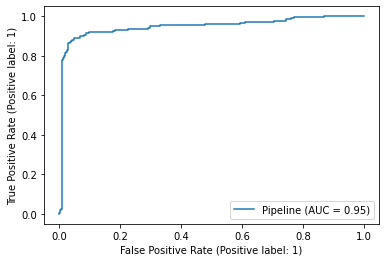

In [24]:
# the shape of the ROC curve and the AUC value denotes a very good
# quality of the classifier
RocCurveDisplay.from_estimator(classifier_pipeline, X_test, Y_test)
plt.show()

The generated classifier model will be saved for further usage or deployment.

In [25]:
# save the classifier for further usage
SAVED_CLASSIFIER_FILE = "COVID_fake_news_TFIF_SVC_pipeline.joblib"
_ = dump(classifier_pipeline, SAVED_CLASSIFIER_FILE)

We will also perform a basic test to ensure that the loaded model is consistent with the original model in its predictions.

In [26]:
# load the classifer and ensure it behaves
# in the same manner as the original one
loaded_classifier_pipeline = load(SAVED_CLASSIFIER_FILE)

Y_pred_loaded = loaded_classifier_pipeline.predict(X_test)
np.testing.assert_array_equal(Y_pred_loaded, Y_pred)

print("The classifier has been successfuly saved.")

The classifier has been successfuly saved.
